# Setup Env

In [1]:
!pip install PyYAML==5.3.1

     |████████████████████████████████| 269 kB 4.3 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=8add02218aa1af1dca73299d126537e5a1fcea62d951031642eb922617b81e79
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from google_drive_downloader import GoogleDriveDownloader
import shutil
import numpy as np
import matplotlib.pyplot as plt
import argparse
from pathlib import Path
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.autograd as autograd
import torch.nn as nn
import os
import cv2
import time
from scipy.ndimage.filters import gaussian_filter
from collections import OrderedDict


In [14]:
GoogleDriveDownloader.download_file_from_google_drive(file_id='1EULkcH_hhSU28qVc1jSJpCh2hGOrzpjK', dest_path='./model/body_pose_model.pth',unzip=False) 
GoogleDriveDownloader.download_file_from_google_drive(file_id='1ZNJDzQUjo2lDPwGoVkRLg77eA57dKUqx', dest_path='./data/hit_kick_data.zip',unzip=True)
GoogleDriveDownloader.download_file_from_google_drive(file_id='1MZvrLgzt72m7gatg72-ST8cl0MrG-XwY', dest_path='./test.mp4',unzip=False)
GoogleDriveDownloader.download_file_from_google_drive(file_id='1b1Y9NEB40p59V9o35hRqp3Gu26czMSUD', dest_path='./model/torch_classifier.h5',unzip=False)


# Models

In [20]:
class MainTask:
    def __init__(self):
        self.colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0)]
        self.download_model_data()
        self.person_detector = PersonDetection()
        self.open_pose_detector = Body('model/body_pose_model.pth')
        self.action_detector = ActionDetection('model/torch_classifier.h5')
        self.frame_list = []
        self.body_points = []
        self.actions = None

    @staticmethod
    def download_model_data():
        #GoogleDriveDownloader.download_file_from_google_drive(file_id='1EULkcH_hhSU28qVc1jSJpCh2hGOrzpjK',
        #                                                      dest_path='./model/body_pose_model.pth', unzip=False)
        #GoogleDriveDownloader.download_file_from_google_drive(file_id='1ZNJDzQUjo2lDPwGoVkRLg77eA57dKUqx',
        #                                                      dest_path='./data/hit_kick_data.zip', unzip=True)
        pass

    @staticmethod
    def draw_polygon(image, points, color, thickness, text):
        points_len = len(points)
        for i in range(0, points_len):
            p0 = tuple(points[i])
            p1 = tuple(points[(i + 1) % points_len])
            image = cv2.line(image, p0, p1, color, thickness=thickness)

        image = cv2.putText(image, text, points[3], cv2.FONT_HERSHEY_SIMPLEX,
                            1, color, 1, 1)

        return image

    def draw_rect(self,image, rect, color, thickness, text):
        l, t, r, b, _, _ = [int(x) for x in rect]
        image = self.draw_polygon(image, [(l, t), (r, t), (r, b), (l, b)], color, thickness, text)
        return image

    def create_frames_loader(self, video_path):
        return self.person_detector.create_dataset(video_path)

    def detect_person(self,frames):
        for path, im, im0s, vid_cap, s in frames:
            results = self.person_detector.model(im)
            self.frame_list.append(results)
            results.print()

    def detect_body_parts(self):
        imgs = []
        for frame_i in self.frame_list:
            crops = frame_i.crop(save=False)
            for crop_i in crops:
                img = crop_i['im']
                imgs.append(img)
                candidate, subset = self.open_pose_detector(img)
                try:
                    #candidate[:, 0] = candidate[:, 0]
                    #candidate[:, 1] = candidate[:, 1]
                    candidate = np.concatenate([candidate, [[0.0, 0.0, 0.0, 0.0]]])
                    candidate = candidate[subset[0, :-2].astype('int'), 0:2]
                except:
                    candidate = np.zeros((18, 2))
                self.body_points.append(candidate)
                break

        %matplotlib inline
        canvas = draw_bodypose(img, candidate[:,:], subset[[0]])
        plt.imshow(canvas[:, :, [2, 1, 0]]) 

    def get_actions(self):
        self.actions = self.action_detector.recognize_actions(self.body_points)


    def finalize(self):

        if os.path.exists('output'):
            shutil.rmtree('output')
        os.mkdir('output')
        h, w = self.frame_list[0].imgs[0].shape[0:2]
        out_file = cv2.VideoWriter('out.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, (w, h))
        for i, (frame_i, action) in enumerate(zip(self.frame_list, self.actions)):
            img = frame_i.imgs[0][..., ::-1]
            bbox = frame_i.xyxy[0].tolist()[0]
            print(i, bbox, action)
            img = self.draw_rect(img, bbox, self.colors[action], 2, self.action_detector.action_dict[action])
            cv2.imwrite(f'output/{i:05}.jpg', img)
            out_file.write(img)
        out_file.release()


In [21]:
#Person Detection

class Frames:
    VID_FORMATS = ['mp4', 'mov', 'asf', 'avi', 'gif', 'm4v', 'mkv', 'mpeg', 'mpg', 'wmv']

    def __init__(self, video_input, img_size=640, stride=32, auto=True):

        p = str(Path(video_input).resolve())
        if os.path.isfile(video_input):
            files = [video_input]
        else:
            raise Exception(f'ERROR: {p} not found')

        self.files = [x for x in files if x.split('.')[-1].lower() in self.VID_FORMATS]

        self.nf = len(files)
        self.stride = stride
        self.new_video(files[0])
        self.auto = auto
        self.img_size = img_size

    def new_video(self, path):
        self.frame = 0
        self.capture = cv2.VideoCapture(path)
        self.frames = int(self.capture.get(cv2.CAP_PROP_FRAME_COUNT))

    def __len__(self):
        return self.n_f

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count == self.nf:
            raise StopIteration
        path = self.files[self.count]

        ret_val, img0 = self.capture.read()
        while not ret_val:
            self.count += 1
            self.capture.release()
            if self.count == self.nf:  # last video
                raise StopIteration
            else:
                path = self.files[self.count]
                self.new_video(path)
                ret_val, img0 = self.cap.read()

        self.frame += 1
        s = f'video {self.count + 1}/{self.nf} ({self.frame}/{self.frames}) {path}:'

        # Padded resize
        img = self.letterbox(img0, self.img_size, stride=self.stride, auto=self.auto)[0]

        # Convert
        img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)

        return path, img, img0, self.capture, s

    @staticmethod
    def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
        # Resize and pad image while meeting stride-multiple constraints
        shape = im.shape[:2]  # current shape [height, width]
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not scaleup:  # only scale down, do not scale up (for better val mAP)
            r = min(r, 1.0)

        # Compute padding
        ratio = r, r  # width, height ratios
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if auto:  # minimum rectangle
            dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
        elif scaleFill:  # stretch
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        dw /= 2  # divide padding into 2 sides
        dh /= 2

        if shape[::-1] != new_unpad:  # resize
            im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
        return im, ratio, (dw, dh)


class PersonDetection():
    def __init__(self):
        model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
        model.classes = [0]
        self.model = model


    @staticmethod
    def create_dataset(video_file):
        video_file = str(video_file)
        imgsz = (640, 640)
        stride = 32

        data = Frames(video_file, img_size=imgsz, stride=stride, auto=True)

        return data


In [22]:
#Open Pose

def draw_bodypose(canvas, candidate, subset):
    stickwidth = 4
    limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
               [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
               [1, 16], [16, 18], [3, 17], [6, 18]]

    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
    for i in range(18):
        for n in range(len(subset)):
            index = int(subset[n][i])
            if index == -1:
                continue
            x, y = candidate[index][0:2]
            cv2.circle(canvas, (int(x), int(y)), 4, colors[i], thickness=-1)
    for i in range(17):
        for n in range(len(subset)):
            index = subset[n][np.array(limbSeq[i]) - 1]
            if -1 in index:
                continue
            cur_canvas = canvas.copy()
            Y = candidate[index.astype(int), 0]
            X = candidate[index.astype(int), 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
    # plt.imsave("preview.jpg", canvas[:, :, [2, 1, 0]])
    # plt.imshow(canvas[:, :, [2, 1, 0]])
    return canvas

def padRightDownCorner(img, stride, padValue):
    h = img.shape[0]
    w = img.shape[1]

    pad = 4 * [None]
    pad[0] = 0 # up
    pad[1] = 0 # left
    pad[2] = 0 if (h % stride == 0) else stride - (h % stride) # down
    pad[3] = 0 if (w % stride == 0) else stride - (w % stride) # right

    img_padded = img
    pad_up = np.tile(img_padded[0:1, :, :]*0 + padValue, (pad[0], 1, 1))
    img_padded = np.concatenate((pad_up, img_padded), axis=0)
    pad_left = np.tile(img_padded[:, 0:1, :]*0 + padValue, (1, pad[1], 1))
    img_padded = np.concatenate((pad_left, img_padded), axis=1)
    pad_down = np.tile(img_padded[-2:-1, :, :]*0 + padValue, (pad[2], 1, 1))
    img_padded = np.concatenate((img_padded, pad_down), axis=0)
    pad_right = np.tile(img_padded[:, -2:-1, :]*0 + padValue, (1, pad[3], 1))
    img_padded = np.concatenate((img_padded, pad_right), axis=1)

    return img_padded, pad

def padRightDownCorner(img, stride, padValue):
    h = img.shape[0]
    w = img.shape[1]

    pad = 4 * [None]
    pad[0] = 0 # up
    pad[1] = 0 # left
    pad[2] = 0 if (h % stride == 0) else stride - (h % stride) # down
    pad[3] = 0 if (w % stride == 0) else stride - (w % stride) # right

    img_padded = img
    pad_up = np.tile(img_padded[0:1, :, :]*0 + padValue, (pad[0], 1, 1))
    img_padded = np.concatenate((pad_up, img_padded), axis=0)
    pad_left = np.tile(img_padded[:, 0:1, :]*0 + padValue, (1, pad[1], 1))
    img_padded = np.concatenate((pad_left, img_padded), axis=1)
    pad_down = np.tile(img_padded[-2:-1, :, :]*0 + padValue, (pad[2], 1, 1))
    img_padded = np.concatenate((img_padded, pad_down), axis=0)
    pad_right = np.tile(img_padded[:, -2:-1, :]*0 + padValue, (1, pad[3], 1))
    img_padded = np.concatenate((img_padded, pad_right), axis=1)

    return img_padded, pad

def transfer(model, model_weights):
    transfered_model_weights = {}
    for weights_name in model.state_dict().keys():
        transfered_model_weights[weights_name] = model_weights['.'.join(weights_name.split('.')[1:])]
    return transfered_model_weights

def make_layers(block, no_relu_layers):
    layers = []
    for layer_name, v in block.items():
        if 'pool' in layer_name:
            layer = nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                    padding=v[2])
            layers.append((layer_name, layer))
        else:
            conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                               kernel_size=v[2], stride=v[3],
                               padding=v[4])
            layers.append((layer_name, conv2d))
            if layer_name not in no_relu_layers:
                layers.append(('relu_'+layer_name, nn.ReLU(inplace=True)))

    return nn.Sequential(OrderedDict(layers))


class BodyPoseModel(nn.Module):
    def __init__(self):
        super(BodyPoseModel, self).__init__()

        # these layers have no relu layer
        no_relu_layers = ['conv5_5_CPM_L1', 'conv5_5_CPM_L2', 'Mconv7_stage2_L1',\
                          'Mconv7_stage2_L2', 'Mconv7_stage3_L1', 'Mconv7_stage3_L2',\
                          'Mconv7_stage4_L1', 'Mconv7_stage4_L2', 'Mconv7_stage5_L1',\
                          'Mconv7_stage5_L2', 'Mconv7_stage6_L1', 'Mconv7_stage6_L1']
        blocks = {}
        block0 = OrderedDict([
                      ('conv1_1', [3, 64, 3, 1, 1]),
                      ('conv1_2', [64, 64, 3, 1, 1]),
                      ('pool1_stage1', [2, 2, 0]),
                      ('conv2_1', [64, 128, 3, 1, 1]),
                      ('conv2_2', [128, 128, 3, 1, 1]),
                      ('pool2_stage1', [2, 2, 0]),
                      ('conv3_1', [128, 256, 3, 1, 1]),
                      ('conv3_2', [256, 256, 3, 1, 1]),
                      ('conv3_3', [256, 256, 3, 1, 1]),
                      ('conv3_4', [256, 256, 3, 1, 1]),
                      ('pool3_stage1', [2, 2, 0]),
                      ('conv4_1', [256, 512, 3, 1, 1]),
                      ('conv4_2', [512, 512, 3, 1, 1]),
                      ('conv4_3_CPM', [512, 256, 3, 1, 1]),
                      ('conv4_4_CPM', [256, 128, 3, 1, 1])
                  ])


        # Stage 1
        block1_1 = OrderedDict([
                        ('conv5_1_CPM_L1', [128, 128, 3, 1, 1]),
                        ('conv5_2_CPM_L1', [128, 128, 3, 1, 1]),
                        ('conv5_3_CPM_L1', [128, 128, 3, 1, 1]),
                        ('conv5_4_CPM_L1', [128, 512, 1, 1, 0]),
                        ('conv5_5_CPM_L1', [512, 38, 1, 1, 0])
                    ])

        block1_2 = OrderedDict([
                        ('conv5_1_CPM_L2', [128, 128, 3, 1, 1]),
                        ('conv5_2_CPM_L2', [128, 128, 3, 1, 1]),
                        ('conv5_3_CPM_L2', [128, 128, 3, 1, 1]),
                        ('conv5_4_CPM_L2', [128, 512, 1, 1, 0]),
                        ('conv5_5_CPM_L2', [512, 19, 1, 1, 0])
                    ])
        blocks['block1_1'] = block1_1
        blocks['block1_2'] = block1_2

        self.model0 = make_layers(block0, no_relu_layers)

        # Stages 2 - 6
        for i in range(2, 7):
            blocks['block%d_1' % i] = OrderedDict([
                    ('Mconv1_stage%d_L1' % i, [185, 128, 7, 1, 3]),
                    ('Mconv2_stage%d_L1' % i, [128, 128, 7, 1, 3]),
                    ('Mconv3_stage%d_L1' % i, [128, 128, 7, 1, 3]),
                    ('Mconv4_stage%d_L1' % i, [128, 128, 7, 1, 3]),
                    ('Mconv5_stage%d_L1' % i, [128, 128, 7, 1, 3]),
                    ('Mconv6_stage%d_L1' % i, [128, 128, 1, 1, 0]),
                    ('Mconv7_stage%d_L1' % i, [128, 38, 1, 1, 0])
                ])

            blocks['block%d_2' % i] = OrderedDict([
                    ('Mconv1_stage%d_L2' % i, [185, 128, 7, 1, 3]),
                    ('Mconv2_stage%d_L2' % i, [128, 128, 7, 1, 3]),
                    ('Mconv3_stage%d_L2' % i, [128, 128, 7, 1, 3]),
                    ('Mconv4_stage%d_L2' % i, [128, 128, 7, 1, 3]),
                    ('Mconv5_stage%d_L2' % i, [128, 128, 7, 1, 3]),
                    ('Mconv6_stage%d_L2' % i, [128, 128, 1, 1, 0]),
                    ('Mconv7_stage%d_L2' % i, [128, 19, 1, 1, 0])
                ])

        for k in blocks.keys():
            blocks[k] = make_layers(blocks[k], no_relu_layers)

        self.model1_1 = blocks['block1_1']
        self.model2_1 = blocks['block2_1']
        self.model3_1 = blocks['block3_1']
        self.model4_1 = blocks['block4_1']
        self.model5_1 = blocks['block5_1']
        self.model6_1 = blocks['block6_1']

        self.model1_2 = blocks['block1_2']
        self.model2_2 = blocks['block2_2']
        self.model3_2 = blocks['block3_2']
        self.model4_2 = blocks['block4_2']
        self.model5_2 = blocks['block5_2']
        self.model6_2 = blocks['block6_2']

    def forward(self, x):

        out1 = self.model0(x)

        out1_1 = self.model1_1(out1)
        out1_2 = self.model1_2(out1)
        out2 = torch.cat([out1_1, out1_2, out1], 1)

        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)
        out3 = torch.cat([out2_1, out2_2, out1], 1)

        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)
        out4 = torch.cat([out3_1, out3_2, out1], 1)

        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)
        out5 = torch.cat([out4_1, out4_2, out1], 1)

        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)
        out6 = torch.cat([out5_1, out5_2, out1], 1)

        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)

        return out6_1, out6_2


class Body(object):
    def __init__(self, model_path):
        self.model = BodyPoseModel()
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        model_dict = transfer(self.model, torch.load(model_path))
        self.model.load_state_dict(model_dict)
        self.model.eval()

    def __call__(self, oriImg):
        # scale_search = [0.5, 1.0, 1.5, 2.0]
        scale_search = [0.5]
        boxsize = 368
        stride = 8
        padValue = 128
        thre1 = 0.1
        thre2 = 0.05
        multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
        heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
        paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

        for m in range(len(multiplier)):
            scale = multiplier[m]
            imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
            imageToTest_padded, pad = padRightDownCorner(imageToTest, stride, padValue)
            im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
            im = np.ascontiguousarray(im)

            data = torch.from_numpy(im).float()
            if torch.cuda.is_available():
                data = data.cuda()
            # data = data.permute([2, 0, 1]).unsqueeze(0).float()
            with torch.no_grad():
                Mconv7_stage6_L1, Mconv7_stage6_L2 = self.model(data)
            Mconv7_stage6_L1 = Mconv7_stage6_L1.cpu().numpy()
            Mconv7_stage6_L2 = Mconv7_stage6_L2.cpu().numpy()

            # extract outputs, resize, and remove padding
            # heatmap = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[1]].data), (1, 2, 0))  # output 1 is heatmaps
            heatmap = np.transpose(np.squeeze(Mconv7_stage6_L2), (1, 2, 0))  # output 1 is heatmaps
            heatmap = cv2.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
            heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
            heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

            # paf = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[0]].data), (1, 2, 0))  # output 0 is PAFs
            paf = np.transpose(np.squeeze(Mconv7_stage6_L1), (1, 2, 0))  # output 0 is PAFs
            paf = cv2.resize(paf, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
            paf = paf[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
            paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

            heatmap_avg += heatmap_avg + heatmap / len(multiplier)
            paf_avg += + paf / len(multiplier)

        all_peaks = []
        peak_counter = 0

        for part in range(18):
            map_ori = heatmap_avg[:, :, part]
            one_heatmap = gaussian_filter(map_ori, sigma=3)

            map_left = np.zeros(one_heatmap.shape)
            map_left[1:, :] = one_heatmap[:-1, :]
            map_right = np.zeros(one_heatmap.shape)
            map_right[:-1, :] = one_heatmap[1:, :]
            map_up = np.zeros(one_heatmap.shape)
            map_up[:, 1:] = one_heatmap[:, :-1]
            map_down = np.zeros(one_heatmap.shape)
            map_down[:, :-1] = one_heatmap[:, 1:]

            peaks_binary = np.logical_and.reduce(
                (one_heatmap >= map_left, one_heatmap >= map_right, one_heatmap >= map_up, one_heatmap >= map_down, one_heatmap > thre1))
            peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
            peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks]
            peak_id = range(peak_counter, peak_counter + len(peaks))
            peaks_with_score_and_id = [peaks_with_score[i] + (peak_id[i],) for i in range(len(peak_id))]

            all_peaks.append(peaks_with_score_and_id)
            peak_counter += len(peaks)

        # find connection in the specified sequence, center 29 is in the position 15
        limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
                   [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
                   [1, 16], [16, 18], [3, 17], [6, 18]]
        # the middle joints heatmap correpondence
        mapIdx = [[31, 32], [39, 40], [33, 34], [35, 36], [41, 42], [43, 44], [19, 20], [21, 22], \
                  [23, 24], [25, 26], [27, 28], [29, 30], [47, 48], [49, 50], [53, 54], [51, 52], \
                  [55, 56], [37, 38], [45, 46]]

        connection_all = []
        special_k = []
        mid_num = 10

        for k in range(len(mapIdx)):
            score_mid = paf_avg[:, :, [x - 19 for x in mapIdx[k]]]
            candA = all_peaks[limbSeq[k][0] - 1]
            candB = all_peaks[limbSeq[k][1] - 1]
            nA = len(candA)
            nB = len(candB)
            indexA, indexB = limbSeq[k]
            if (nA != 0 and nB != 0):
                connection_candidate = []
                for i in range(nA):
                    for j in range(nB):
                        vec = np.subtract(candB[j][:2], candA[i][:2])
                        norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                        norm = max(0.001, norm)
                        vec = np.divide(vec, norm)

                        startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                            np.linspace(candA[i][1], candB[j][1], num=mid_num)))

                        vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                          for I in range(len(startend))])
                        vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                          for I in range(len(startend))])

                        score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                        score_with_dist_prior = sum(score_midpts) / len(score_midpts) + min(
                            0.5 * oriImg.shape[0] / norm - 1, 0)
                        criterion1 = len(np.nonzero(score_midpts > thre2)[0]) > 0.8 * len(score_midpts)
                        criterion2 = score_with_dist_prior > 0
                        if criterion1 and criterion2:
                            connection_candidate.append(
                                [i, j, score_with_dist_prior, score_with_dist_prior + candA[i][2] + candB[j][2]])

                connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
                connection = np.zeros((0, 5))
                for c in range(len(connection_candidate)):
                    i, j, s = connection_candidate[c][0:3]
                    if (i not in connection[:, 3] and j not in connection[:, 4]):
                        connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                        if (len(connection) >= min(nA, nB)):
                            break

                connection_all.append(connection)
            else:
                special_k.append(k)
                connection_all.append([])

        subset = -1 * np.ones((0, 20))
        candidate = np.array([item for sublist in all_peaks for item in sublist])

        for k in range(len(mapIdx)):
            if k not in special_k:
                partAs = connection_all[k][:, 0]
                partBs = connection_all[k][:, 1]
                indexA, indexB = np.array(limbSeq[k]) - 1

                for i in range(len(connection_all[k])):  # = 1:size(temp,1)
                    found = 0
                    subset_idx = [-1, -1]
                    for j in range(len(subset)):  # 1:size(subset,1):
                        if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                            subset_idx[found] = j
                            found += 1

                    if found == 1:
                        j = subset_idx[0]
                        if subset[j][indexB] != partBs[i]:
                            subset[j][indexB] = partBs[i]
                            subset[j][-1] += 1
                            subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                    elif found == 2:  # if found 2 and disjoint, merge them
                        j1, j2 = subset_idx
                        membership = ((subset[j1] >= 0).astype(int) + (subset[j2] >= 0).astype(int))[:-2]
                        if len(np.nonzero(membership == 2)[0]) == 0:  # merge
                            subset[j1][:-2] += (subset[j2][:-2] + 1)
                            subset[j1][-2:] += subset[j2][-2:]
                            subset[j1][-2] += connection_all[k][i][2]
                            subset = np.delete(subset, j2, 0)
                        else:  # as like found == 1
                            subset[j1][indexB] = partBs[i]
                            subset[j1][-1] += 1
                            subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                    # if find no partA in the subset, create a new subset
                    elif not found and k < 17:
                        row = -1 * np.ones(20)
                        row[indexA] = partAs[i]
                        row[indexB] = partBs[i]
                        row[-1] = 2
                        row[-2] = sum(candidate[connection_all[k][i, :2].astype(int), 2]) + connection_all[k][i][2]
                        subset = np.vstack([subset, row])
        # delete some rows of subset which has few parts occur
        deleteIdx = []
        for i in range(len(subset)):
            if subset[i][-1] < 4 or subset[i][-2] / subset[i][-1] < 0.4:
                deleteIdx.append(i)
        subset = np.delete(subset, deleteIdx, axis=0)

        # subset: n*20 array, 0-17 is the index in candidate, 18 is the total score, 19 is the total parts
        # candidate: x, y, score, id
        return candidate, subset


In [23]:
#Action Recognition Model

class ActionDetection:
    def __init__(self, model_path):
        self.angle_idx = [[2, 3], [3, 4], [5, 6], [6, 7], [8, 9], [9, 10], [11, 12], [12, 13]]
        self.dist_idx = [3, 4, 6, 7, 9, 10, 12, 13]
        self.action_dict = {0: 'Standing', 1: 'Walking', 2: 'Hitting', 3: 'Kicking'}
        #self.model = LSTMClassifier(64,4)
        self.model = torch.load(model_path)
        self.model.eval()
        if torch.cuda.is_available():
            self.model.cuda()

    def calculate_features(self, body_points):

        features = []
        count = 0
        for bp_i in body_points:

            angles = [self.get_angle(bp_i[i], bp_i[j]) for i, j in self.angle_idx]
            if count == 0:
                bp_i_t = bp_i
                angles_t = np.array(angles)

            delta_angle = abs((np.array(angles) - (angles_t))).tolist()
            delta_dist = [self.get_dist(bp_i_t[j], bp_i[j]) for j in self.dist_idx]

            features.append(angles + delta_angle + delta_dist)
            bp_i_t = bp_i
            angles_t = np.array(angles)
            count = count + 1

        features = np.array(features)
        features = np.concatenate([np.zeros(((features.shape[0] // 32 + 1) * 32 - features.shape[0], 24)), features])
        features = np.expand_dims(features, 0)

        return torch.from_numpy(features).float()

    def recognize_actions(self, body_points):

        data = self.calculate_features(body_points)
        out = []
        with torch.no_grad():
            if torch.cuda.is_available():
                for i in range(data.shape[1]):
                    out.append(self.model(data[:, i:i + 32, :].cuda()).argmax(-1).cpu().numpy()[0])
            else:
                for i in range(data.shape[1]):
                    out.append(self.model(data[:, i:i + 32, :]).argmax(-1).numpy()[0])

        return out

    @staticmethod
    def get_dist(joint_1, joint_2):
        x1, y1 = joint_1
        x2, y2 = joint_2
        if (x1 == 0) or (x2 == 0) or (y1 == 0):
            return 0.0
        else:
            return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    @staticmethod
    def get_angle(joint_1, joint_2):
        x1, y1 = joint_1
        x2, y2 = joint_2

        if (x1 == 0) or (x2 == 0):
            return 0.0
        dx = x2 - x1
        dy = y2 - y1
        rad = math.atan2(dy, dx)
        degree = (rad * 180) / math.pi
        if (degree < 0):
            degree = degree + 360
        return degree


"""
class ARTrainer:
    import tensorflow as tf
    def __init__(self, val_ratio=0.1):
        self.val_ratio = val_ratio
        self.train = pd.read_csv('data/pose_36.txt', index_col=None, header=None)
        self.out = pd.read_csv('data/pose36_c.txt', index_col=None, header=None)

    def create_data(self):
        out = pd.get_dummies(self.out[0])
        train = self.train.values
        train = train.reshape(-1, 32, 24)
        print(train.shape)
        out = out.values

        out = np.expand_dims(out, -1).transpose(0, 2, 1)
        out = np.repeat(out, 32, axis=1)
        print(out.shape)

        train_inp, val_inp, train_out, val_out = train_test_split(train, out, test_size=self.val_ratio, shuffle=True)

        return train_inp, val_inp, train_out, val_out

    @classmethod
    def create_tf_model(cls):
        series_input = cls.tf.keras.layers.Input((32, 24))
        series_input = cls.tf.keras.layers.GaussianNoise(0.05)(series_input)
        # x = cls.tf.keras.layers.Dropout(0.25)(series_input)
        x = cls.tf.keras.layers.LSTM(64, dropout=0.2, return_sequences=True)(series_input)
        x = cls.tf.keras.layers.TimeDistributed(cls.tf.keras.layers.Dropout(0.2))(x)
        x = cls.tf.keras.layers.TimeDistributed(cls.tf.keras.layers.Dense(16, activation='relu'))(x)
        x = cls.tf.keras.layers.TimeDistributed(cls.tf.keras.layers.Dropout(0.05))(x)
        x = cls.tf.keras.layers.TimeDistributed(cls.tf.keras.layers.Dense(4))(x)
        x = cls.tf.keras.layers.TimeDistributed(cls.tf.keras.layers.Softmax())(x)

        return cls.tf.keras.Model(series_input, x)

    @classmethod
    def compile_tf_model(cls, m):
        optimizer = cls.tf.optimizers.Adam(learning_rate=0.001)
        m.compile(optimizer=optimizer, loss=cls.tf.keras.losses.categorical_crossentropy,
                  metrics=cls.tf.keras.metrics.categorical_accuracy)
        return m

    @classmethod
    def create_tf_checkpoint(cls):
        ckpt = cls.tf.keras.callbacks.ModelCheckpoint(
            'model/check_weights.h5', monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='min',
            save_weights_only=True
        )
        return ckpt

    def train_tf_model(self, batch_size):
        train_inp, val_inp, train_out, val_out = self.create_data()
        model = self.create_tf_model()
        model = self.compile_tf_model(model)
        checkpoints = self.create_tf_checkpoint()

        model.fit(x=train_inp, y=train_out, batch_size=batch_size, epochs=250, validation_batch_size=batch_size,
                  validation_data=(val_inp, val_out), callbacks=[checkpoints], shuffle=True)

        model.save('model/classifier.h5', include_optimizer=False)
        model.save_weights('model/classifier_w.h5')

        return model

    def create_tensorflow_pytorh_model(self):
        tf_model = self.train_tf_model(128)
        weights = tf_model.get_weights()
        pt_model = LSTMClassifier(64, 4)

        pt_model.lstm.weight_ih_l0.data = torch.from_numpy(weights[0]).transpose(1, 0).contiguous()
        pt_model.lstm.weight_hh_l0.data = torch.from_numpy(weights[1]).transpose(1, 0).contiguous()

        pt_model.lstm.bias_ih_l0.data = torch.from_numpy(weights[2]).contiguous()
        pt_model.lstm.bias_hh_l0.data = torch.from_numpy(weights[2]).contiguous()

        pt_model.hidden2inter.weight.data = torch.from_numpy(weights[3]).transpose(1, 0).contiguous()
        pt_model.hidden2inter.bias.data = torch.from_numpy(weights[4]).contiguous()
        pt_model.hidden2out.weight.data = torch.from_numpy(weights[5]).transpose(1, 0).contiguous()
        pt_model.hidden2out.bias.data = torch.from_numpy(weights[6]).contiguous()

        torch.save(pt_model, 'model/torch_classifier.h5')
        torch.save(pt_model.state_dict(), 'torch_state.h5')

"""


class LSTMClassifier(nn.Module):

    def __init__(self, hidden_dim, output_size):
        super(LSTMClassifier, self).__init__()

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(24, hidden_dim, num_layers=1, batch_first=True, bidirectional=False)

        self.hidden2inter = nn.Linear(hidden_dim, 16)
        self.act1 = nn.ReLU()
        self.hidden2out = nn.Linear(16, 4)
        self.softmax = nn.LogSoftmax()

    def init_hidden(self, batch_size):
        return (autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)),
                autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)))

    def forward(self, batch):
        self.hidden = self.init_hidden(batch.size(-1))

        output, (ht, ct) = self.lstm(batch)
        # output = output.contiguous().view(-1, self.hidden_dim)
        # ht is the last hidden state of the sequences
        # ht = (1 x batch_size x hidden_dim)
        # ht[-1] = (batch_size x hidden_dim)
        output = self.hidden2inter(ht[-1])  # torch.cat((ht[0], ht[1]), dim=-1))
        output = self.act1(output)
        output = self.hidden2out(output)
        output = self.softmax(output)
        # output = output.contiguous().view(batch.size(0),-1, 4)

        return output



# Run

In [9]:
input_video = 'test.mp4' #@param {type:"string"} 

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-2-7 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 384x640 1 person
Speed: 3.1ms pre-process, 216.5ms inference, 55.4ms NMS per image at shape (1, 3, 384, 640)
image 1/1: 384x640 1 person
Speed: 5.8ms pre-process, 11.2ms inference, 1.9ms NMS per image at shape (1, 3, 384, 640)
image 1/1: 384x640 1 person
Speed: 3.2ms pre-process, 10.5ms inference, 2.1ms NMS per image at shape (1, 3, 384, 640)
image 1/1: 384x640 1 person
Speed: 2.5ms pre-process, 10.6ms inference, 1.9ms NMS per image at shape (1, 3, 384, 640)
image 1/

0 [255.2775115966797, 60.52099609375, 346.604736328125, 352.9250183105469, 0.930297315120697, 0.0] 0
1 [252.4505615234375, 59.3040771484375, 345.87493896484375, 351.39886474609375, 0.9268267154693604, 0.0] 0
2 [250.57765197753906, 61.230224609375, 344.3291931152344, 333.2081604003906, 0.9007244110107422, 0.0] 0
3 [248.7115936279297, 59.08341979980469, 343.9640197753906, 339.8978271484375, 0.8930345177650452, 0.0] 0
4 [243.67288208007812, 59.41862487792969, 338.6297912597656, 342.77728271484375, 0.9089643955230713, 0.0] 0
5 [233.47384643554688, 59.323577880859375, 336.5400085449219, 339.9755859375, 0.8944798707962036, 0.0] 0
6 [225.97442626953125, 58.965545654296875, 335.42303466796875, 334.9757385253906, 0.9159322381019592, 0.0] 0
7 [219.1385040283203, 58.004058837890625, 332.43115234375, 331.919921875, 0.9258459210395813, 0.0] 0
8 [212.07632446289062, 58.149078369140625, 327.4214782714844, 319.8216857910156, 0.934841513633728, 0.0] 0
9 [207.37489318847656, 57.31135559082031, 326.07205

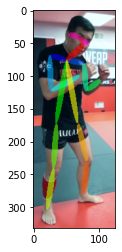

In [24]:
main_task = MainTask()
frame_loader = main_task.create_frames_loader(input_video)
main_task.detect_person(frame_loader)
main_task.detect_body_parts()
main_task.get_actions()
main_task.finalize()